# Config

In [31]:
import torch
BATCH_SIZE = 8 # increase / decrease according to GPU memeory
RESIZE_TO = 416 # resize the image for training and transforms
NUM_EPOCHS = 10 # number of epochs to train for
NUM_WORKERS = 4
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DATASET = "dataset"
# classes: 0 index is reserved for background
CLASSES = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
]
NUM_CLASSES = len(CLASSES)
# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False
# location to save model and plots
OUT_DIR = 'outputs'

- The Averager class is for keeping track of the training and validation loss values. We can also retrieve the average loss after each epoch with help of instances of this class. You may spend some time to properly understand it if you are new to such an Averager class.

- The SaveBestModel class is a very simple function to save the best model after each epoch. We call the instance of this class while passing the current epoch’s validation loss. If that is the best loss, then a new best model is saved to the disk.

In [32]:
import albumentations as A
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
plt.style.use('ggplot')
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/best_model.pth')


- The **collate_fn()** will help us take care of tensors of varying sizes while creating the training and validation data loaders.

- Then we have the **get_train_transform()** and **get_valid_transform()** functions defining the data augmentations for the images. Note that the dataset format is pascal_voc, which is pretty important to mention correctly.

- The **show_tranformed_image()** is for showing the image from the training data loader just before the training begins. This will helps us check that the augmented images and the bounding boxes are indeed correct.

- Then we have function to save the model after each epoch and after training ends.
And another function to save the training and validation loss graphs. This will be called after each epoch.


In [33]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params= A.BboxParams(
        format = 'pascal_voc',
        label_fields = ['labels'],
    ))
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params=A.BboxParams(
        format = 'pascal_voc', 
        label_fields = ['labels'],
    ))
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            labels = targets[i]['labels'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            # Create a Rectangle patch
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                    linewidth=2, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            plt.text(box[0], box[1] - 5, label, color='red')
            
def save_model(epoch, model, optimizer):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, 'outputs/last_model.pth')
def save_loss_plot(OUT_DIR, train_loss, val_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")
    print('SAVING PLOTS COMPLETE...')
    plt.close('all')

# Dataset

In [34]:
from torch.utils.data import Dataset
import cv2
import os
import numpy as np
import torch

class CustomDataset(Dataset):
    def __init__(self, root_dir, transforms=None, train=True):
        self.root_dir = root_dir
        self.transforms = transforms
        self.train = train
        
        # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx].split('.')[0]
        boxes = []
        labels = []
        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (800, 800))
        image_resized /= 255.0
        
        # Load corresponding label file
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                x_min = (x - width / 2) * 800
                y_min = (y - height / 2) * 800
                x_max = (x + width / 2) * 800
                y_max = (y + height / 2) * 800
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_label))
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
        image_id = torch.tensor([int(img_id)])
        target = {"boxes": boxes, "labels": labels, "image_id": image_id, "area": area, "iscrowd": iscrowd}
        
        if self.transforms:
            sample = self.transforms(image = image_resized,
                                     bboxes = target['boxes'],
                                     labels = labels)
            image_resized = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return image_resized, target
        

In [35]:
# prepare the final datasets and data loaders
def create_train_dataset():
    train_dataset = CustomDataset(DATASET, get_train_transform(), train=True)
    return train_dataset
def create_valid_dataset():
    valid_dataset = CustomDataset(DATASET, get_valid_transform(), train=False)
    return valid_dataset

In [36]:
from torch.utils.data import DataLoader

def create_train_loader(train_dataset, num_workers=4):
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return train_loader
def create_valid_loader(valid_dataset, num_workers=4):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    return valid_loader

In [37]:
dataset = CustomDataset(
    root_dir=DATASET,
    transforms=get_train_transform(),
    train=True
)
print(f"Number of training images: {len(dataset)}")

Number of training images: 11725


In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_sample(image, target):
    # Create figure and axes
    fig, ax = plt.subplots(1)
    image = image.permute(1, 2, 0).cpu().numpy()
    # Display the image
    ax.imshow(image)

    for box_num in range(len(target['boxes'])):
        box = target['boxes'][box_num]
        label = CLASSES[target['labels'][box_num]]

        # Create a Rectangle patch
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

        plt.text(box[0], box[1] - 5, label, color='red')

    plt.show()

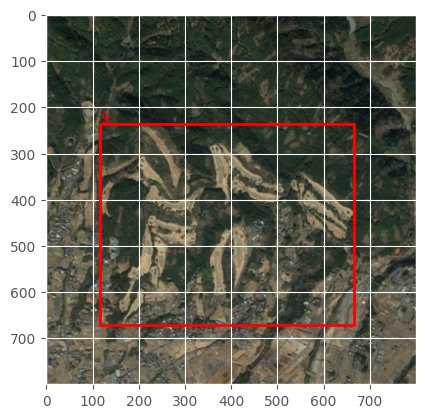

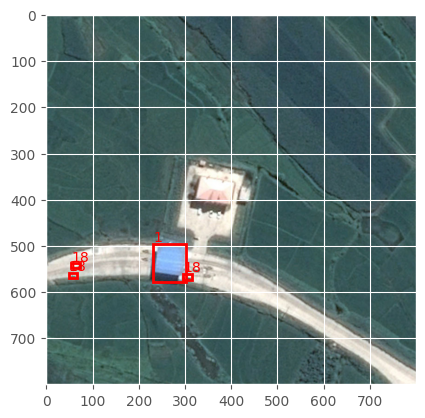

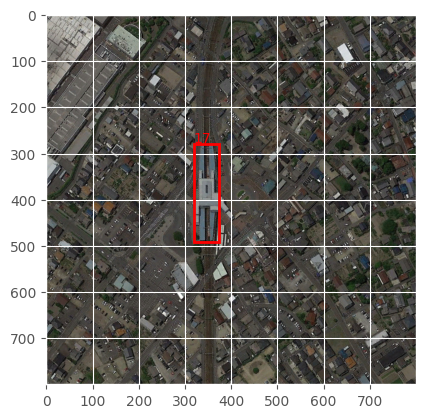

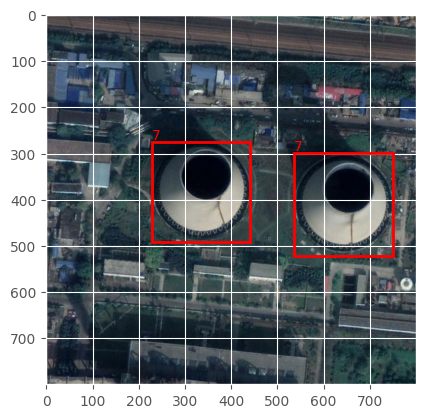

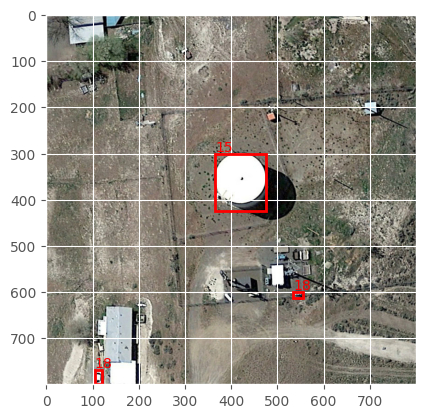

In [39]:
NUM_SAMPLES_TO_VISUALIZE = 5
for i in range(NUM_SAMPLES_TO_VISUALIZE):
    image, target = dataset[i]
    visualize_sample(image, target)

# Model

In [40]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    
    # load Faster RCNN pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    return model

# Train

In [41]:
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [42]:
# function for running training iterations
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [43]:
# function for running validation iterations
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        val_loss_hist.send(loss_value)
        val_itr += 1
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

In [44]:
train_dataset = create_train_dataset()
valid_dataset = create_valid_dataset()
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the model parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till ena and plot graphs for all iterations
train_loss_list = []
val_loss_list = []
# name to save the trained model with
MODEL_NAME = 'FasterRCNN'

Number of training samples: 11725
Number of validation samples: 11738



/home/ec2-user/ObjDct_Master_Thesis/venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/ObjDct_Master_Thesis/venv/lib64/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
if VISUALIZE_TRANSFORMED_IMAGES:
    show_tranformed_image(train_loader)
# initialize SaveBestModel class
save_best_model = SaveBestModel()
# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()
    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} validation loss: {val_loss_hist.value:.3f}")   
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
    # save the best model till now if we have the least loss in the...
    # ... current epoch
    save_best_model(
        val_loss_hist.value, epoch, model, optimizer
    )
    # save the current epoch model
    save_model(epoch, model, optimizer)
    # save loss plot
    save_loss_plot(OUT_DIR, train_loss, val_loss)
    
    # sleep for 5 seconds after each epoch
    time.sleep(5)


EPOCH 1 of 10
Training


Loss: 3.7126:   0%|          | 2/1466 [02:11<26:47:37, 65.89s/it]
